In [1]:
import os
import ROOT
import numpy as np
import h5py
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

Welcome to JupyROOT 6.30/02


In [2]:
def calculate_angle(x, y):
    # atan2 함수를 사용하여 각도를 계산
    angle_rad = np.arctan2(y, x)

    # 라디안을 도로 변환
    angle_deg = np.rad2deg(angle_rad)

    return angle_deg




In [3]:
ROOT.gSystem.Load("/users/yewzzang/WCSim_KNO/WCSim_v1.8.0-build/libWCSimRoot.so")
fin = ROOT.TFile("/store/cpnr/users/yewzzang/KNO_cla_mu/root/mu_500Mev_10.root")
# fin = ROOT.TFile("/store/cpnr/users/yewzzang/KNO_cla_e/root/e_950Mev_1.root")


Warning in <TClassTable::Add>: class WCSimRootCherenkovHit already in TClassTable
Warning in <TClassTable::Add>: class WCSimRootCherenkovDigiHit already in TClassTable
Warning in <TClassTable::Add>: class WCSimRootPi0 already in TClassTable
Warning in <TClassTable::Add>: class WCSimRootTrigger already in TClassTable
Warning in <TClassTable::Add>: class WCSimRootEvent already in TClassTable
Warning in <TClassTable::Add>: class WCSimRootGeom already in TClassTable
Warning in <TFile::Init>: no StreamerInfo found in /users/yewzzang/WCSim_KNO/WCSim_v1.8.0-build/libWCSimRootDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with version 6.28/04 of ROOT.
Error in <TUnixSystem::Load>: version mismatch, /users/yewzzang/WCSim_KNO/WCSim_v1.8.0-build/libWCSimRoot.so = 62804, ROOT = 63002
Warning in <TClassTable::Add>: class WCSimRootTrigger already in TClassTable
Warning in <TClassTable::Add>: class WCSimRootEventHeader already in TClassTable
Warning

In [4]:

eventT = fin.Get("wcsimT")
event = ROOT.WCSimRootEvent()
eventT.SetBranchAddress("wcsimrootevent", event)
eventT.GetBranch("wcsimrootevent").SetAutoDelete(1)
eventT.GetEntry(0)
nEvents = eventT.GetEntries()


In [5]:

## Load the geometry
geomT = fin.Get("wcsimGeoT")
geom = ROOT.WCSimRootGeom()
geomT.SetBranchAddress("wcsimrootgeom", geom)
geomT.GetEntry(0)
nODPMTs = geom.GetODWCNumPMT()
nPMTs = geom.GetWCNumPMT()

print("--------------------")
print(f" nEvents = {nEvents}")
print(f" nPMTs   = {nPMTs}")
print(f" nODPMTs = {nODPMTs}")
print("--------------------")

--------------------
 nEvents = 2000
 nPMTs   = 30912
 nODPMTs = 0
--------------------


In [6]:
out_pmt_x = np.zeros(nPMTs)
out_pmt_y = np.zeros(nPMTs)
out_pmt_z = np.zeros(nPMTs)

out_pmt_px = np.zeros(nPMTs)
out_pmt_py = np.zeros(nPMTs)
out_pmt_pz = np.zeros(nPMTs)

for iPMT in range(nPMTs):
    pmt = geom.GetPMT(iPMT)
    out_pmt_x[iPMT] = pmt.GetPosition(0)
    out_pmt_y[iPMT] = pmt.GetPosition(1)
    out_pmt_z[iPMT] = pmt.GetPosition(2)
    out_pmt_px[iPMT] = pmt.GetOrientation(0)
    out_pmt_py[iPMT] = pmt.GetOrientation(1)
    out_pmt_pz[iPMT] = pmt.GetOrientation(2)

In [7]:
print("@@@ Start analysing data")
out_vtx_x = np.zeros(nEvents)
out_vtx_y = np.zeros(nEvents)
out_vtx_z = np.zeros(nEvents)
out_vtx_t = np.zeros(nEvents)

out_vtx_dx = np.zeros(nEvents)
out_vtx_dy = np.zeros(nEvents)
out_vtx_dz = np.zeros(nEvents)

out_vtx_px = np.zeros(nEvents)
out_vtx_py = np.zeros(nEvents)
out_vtx_pz = np.zeros(nEvents)
out_vtx_ke = np.zeros(nEvents)
out_vtx_ke2 = np.zeros(nEvents)

out_pmt_q = np.zeros((nEvents, nPMTs))
out_pmt_t = np.zeros((nEvents, nPMTs))
for iEvent in tqdm(range(nEvents)):
    eventT.GetEvent(iEvent)
    trigger = event.GetTrigger(0)

    if trigger.GetNvtxs() == 0: continue
    if trigger.GetNtrack() == 0: continue

    out_vtx_x[iEvent] = trigger.GetVtx(0)
    out_vtx_y[iEvent] = trigger.GetVtx(1)
    out_vtx_z[iEvent] = trigger.GetVtx(2)
    out_vtx_t[iEvent] = 0

    firstTrack = trigger.GetTracks()[0]

    out_vtx_dx[iEvent] = firstTrack.GetDir(0)
    out_vtx_dy[iEvent] = firstTrack.GetDir(1)
    out_vtx_dz[iEvent] = firstTrack.GetDir(2)

    out_vtx_px[iEvent] = firstTrack.GetPdir(0)
    out_vtx_py[iEvent] = firstTrack.GetPdir(1)
    out_vtx_pz[iEvent] = firstTrack.GetPdir(2)
    out_vtx_ke[iEvent] = firstTrack.GetE()
    out_vtx_ke2[iEvent] = firstTrack.GetE()-firstTrack.GetM()
    nHitsC = trigger.GetNcherenkovdigihits()
    for iHit in range(nHitsC):
        hit = trigger.GetCherenkovDigiHits().At(iHit)
        iPMT = hit.GetTubeId()-1
        out_pmt_q[iEvent, iPMT] = hit.GetQ()
        out_pmt_t[iEvent, iPMT] = hit.GetT()
        
pmts_num = (np.sum(out_pmt_q>0,axis=1) > 1000)
dis = (np.linalg.norm(np.zeros((3,2000))-[out_vtx_x,out_vtx_y,out_vtx_z],axis=0)<3500)

out_vtx_x = out_vtx_x[pmts_num & dis]
out_vtx_y = out_vtx_y[pmts_num & dis]
out_vtx_z = out_vtx_z[pmts_num & dis]
out_vtx_t = out_vtx_t[pmts_num & dis]

out_vtx_px = out_vtx_px[pmts_num & dis]
out_vtx_py = out_vtx_py[pmts_num & dis]
out_vtx_pz = out_vtx_pz[pmts_num & dis]
out_vtx_ke = out_vtx_ke[pmts_num & dis]
out_vtx_ke2 = out_vtx_ke2[pmts_num & dis]

out_pmt_t = out_pmt_t[pmts_num & dis]
out_pmt_q = out_pmt_q[pmts_num & dis]

@@@ Start analysing data


100%|██████████| 2000/2000 [00:20<00:00, 98.63it/s] 


[-815.93333878 3853.87405151 -615.97872204]


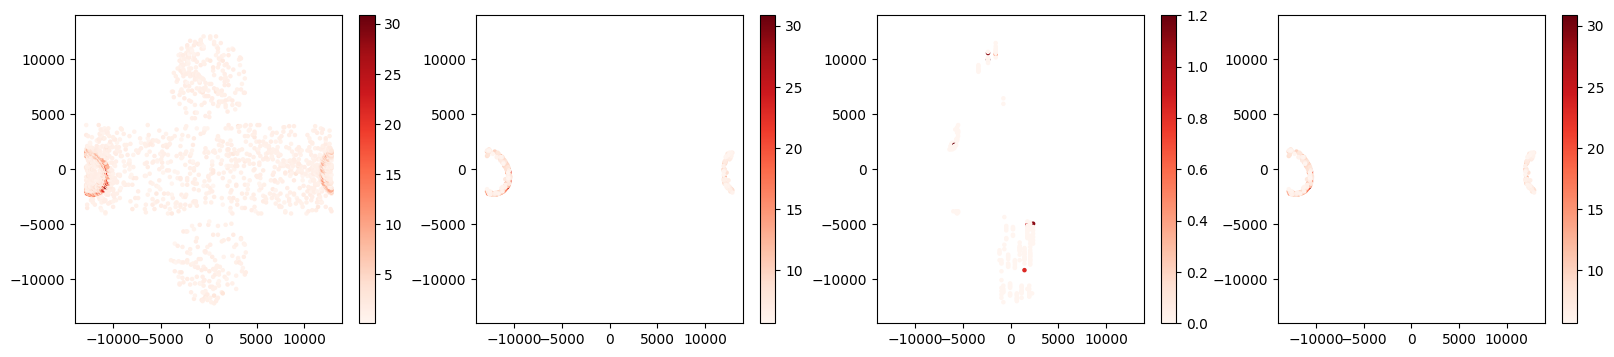

[ 4039.50275696   376.43665718 -1637.84097137]


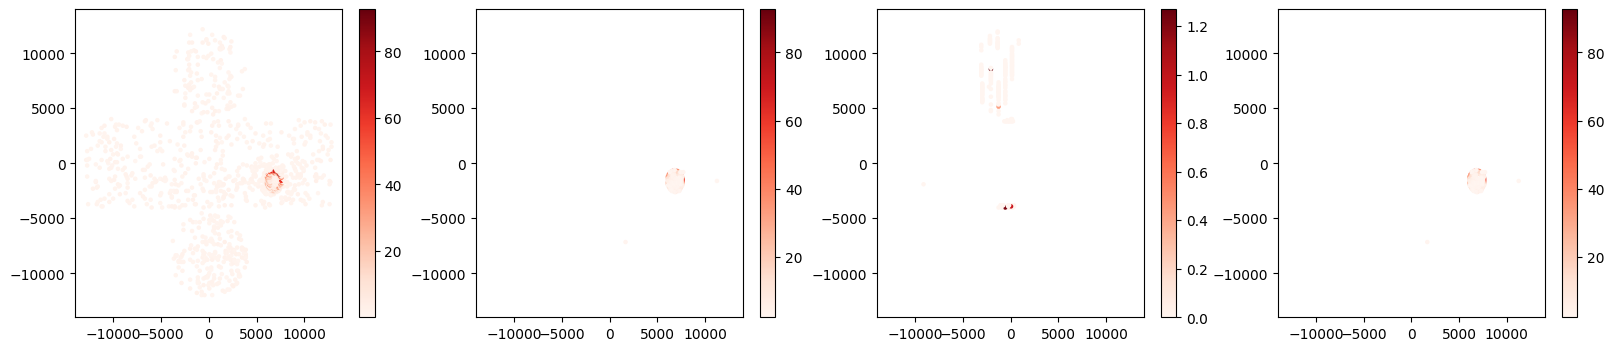

[ 581.80723171 2668.727577   1906.30649364]


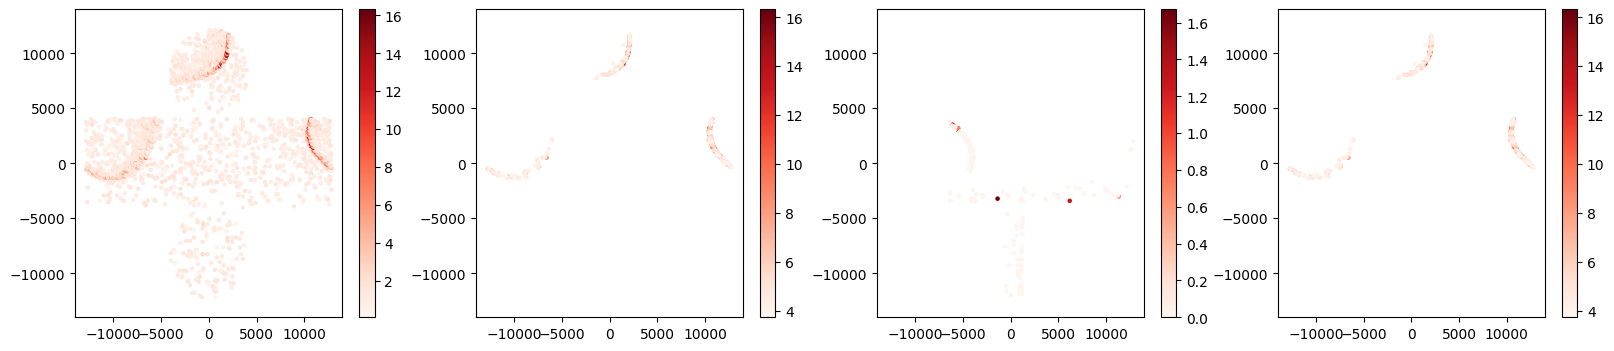

[ -63.7302767   786.37883635 3485.55607178]


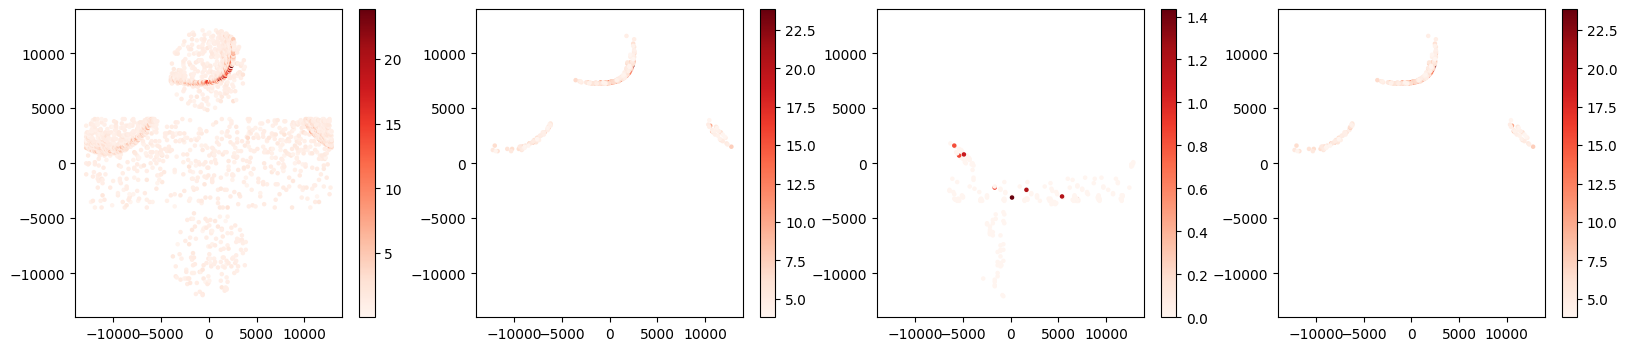

[2841.21642883 -241.33802933 2560.25580963]


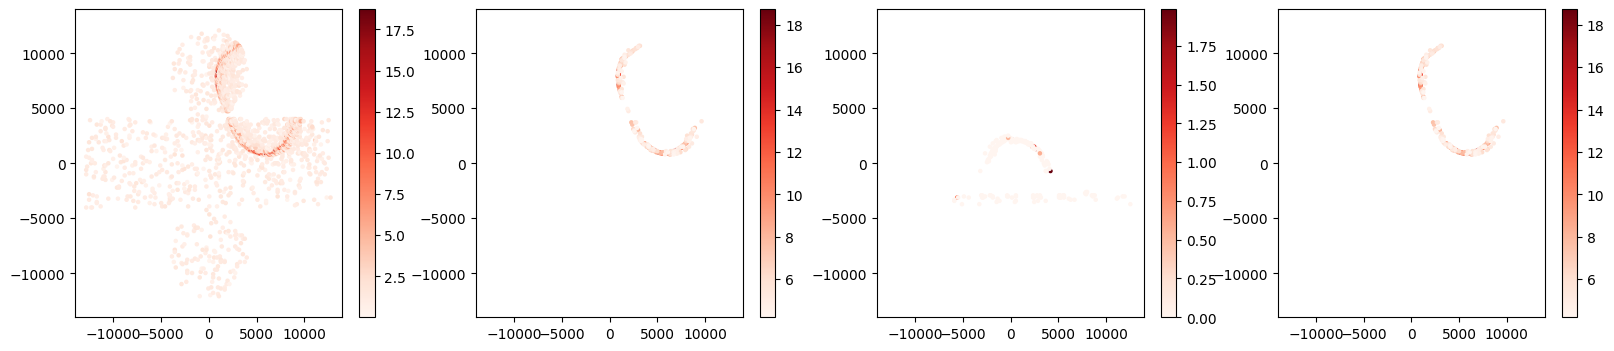

[ -431.54153511 -3210.42378052  2139.93626976]


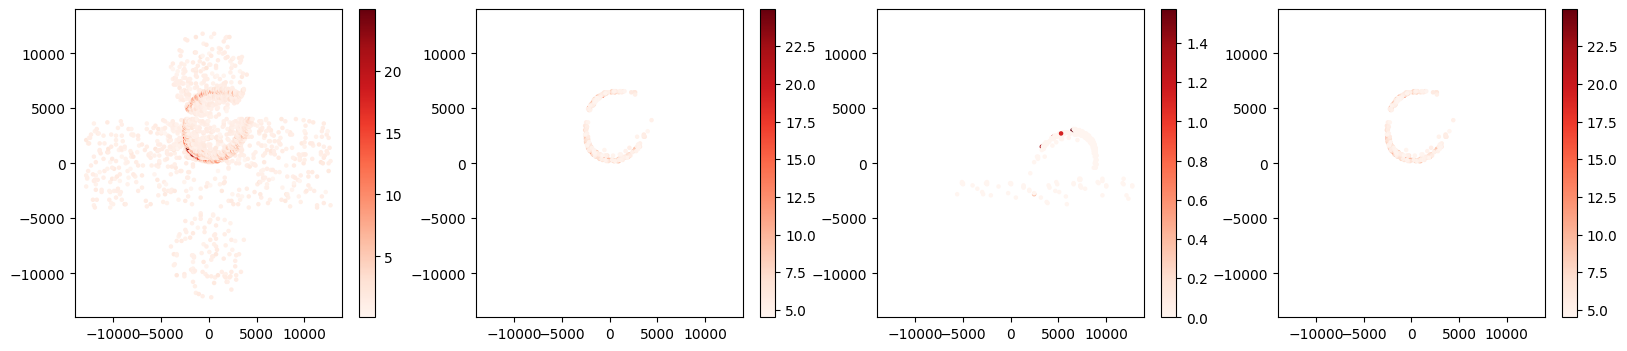

[-3928.54400879  -126.68459145  -212.52773041]


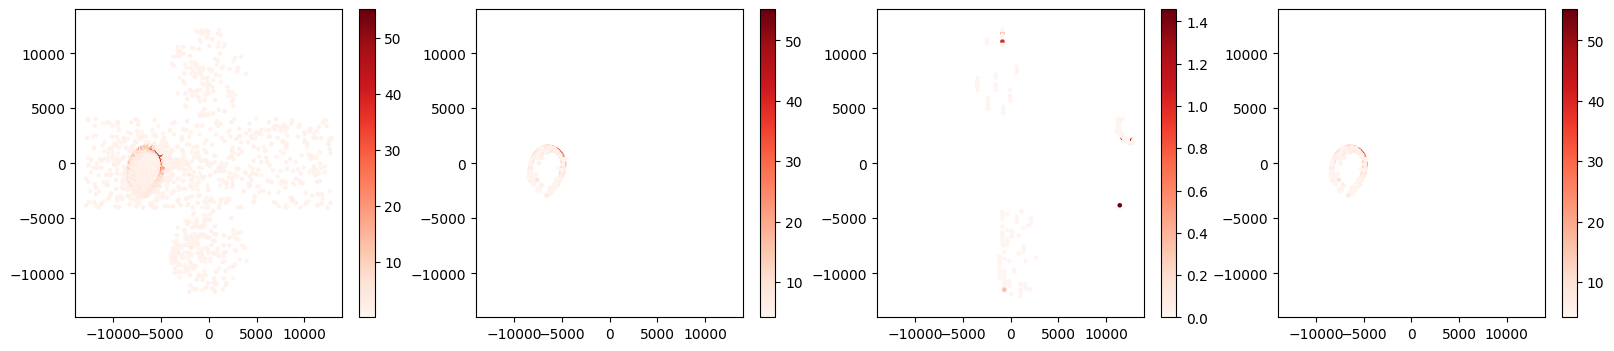

[-1618.63951416  1881.91660824  2067.40241234]


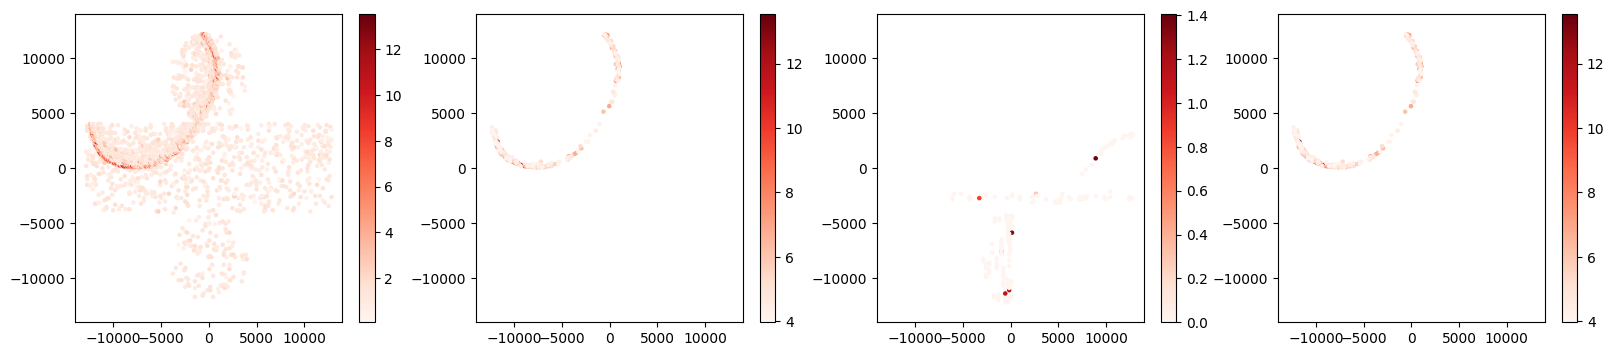

[  808.54183695  -141.46313602 -3794.18231689]


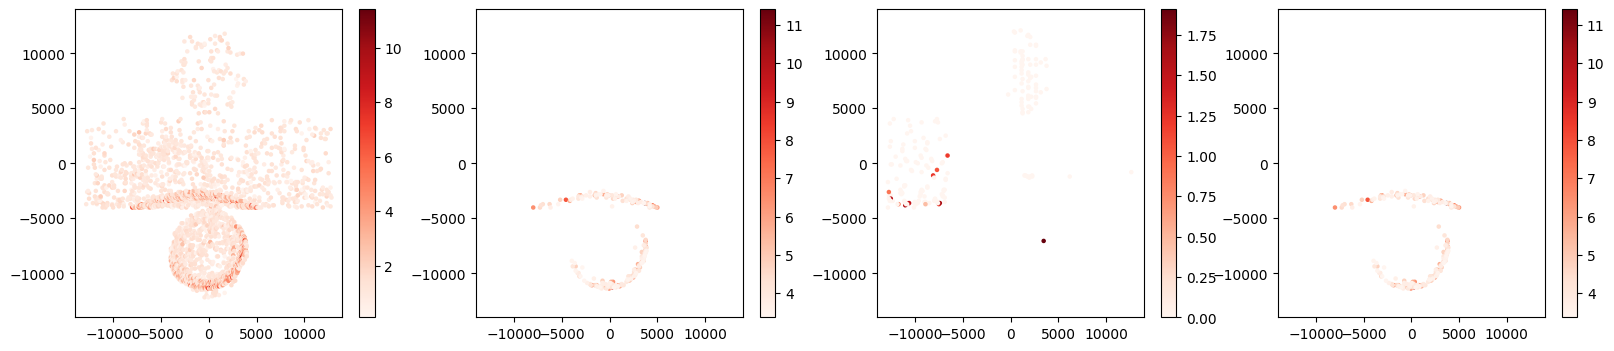

[-1715.55693729   300.53715363 -3138.14896118]


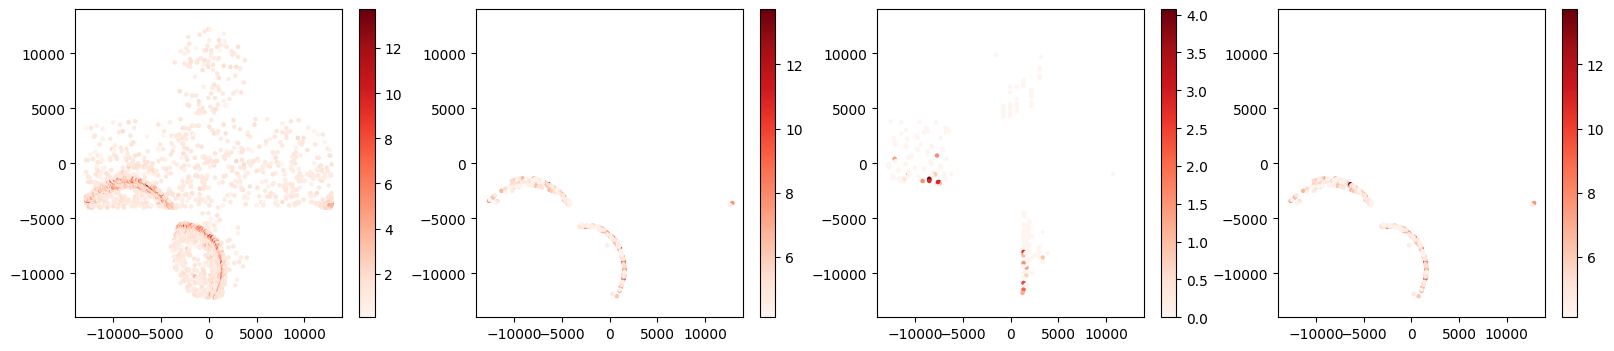

In [58]:
for i in range(10):
    


    # plt.rcParams['figure.figsize'] = (8, 5) 
    shift = 4106.4609*2*np.pi/4

    side_x1 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())], out_pmt_y[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())])/360)
    side_z1 = out_pmt_z[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())]


    side_x11 = side_x1[side_x1>shift]-3*shift
    side_z11 = side_z1[side_x1>shift]
    charge_1 = out_pmt_q[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x1>shift]
    time_1 = out_pmt_t[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x1>shift]


    side_x2 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())], out_pmt_y[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())])/360)
    side_z2 = out_pmt_z[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())]

    side_x21 = side_x1[side_x2<=shift]+shift
    side_z21 = side_z1[side_x2<=shift]
    charge_2 = out_pmt_q[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x2<=shift]
    time_2 = out_pmt_t[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x2<=shift]


    top_x = out_pmt_x[out_pmt_z>=out_pmt_z.max()]
    top_z = (out_pmt_z[out_pmt_z>=out_pmt_z.max()]+out_pmt_y[out_pmt_z>=out_pmt_z.max()]+4106.4609)
    charge_top = out_pmt_q[i][out_pmt_z>=out_pmt_z.max()]
    time_top = out_pmt_t[i][out_pmt_z>=out_pmt_z.max()]


    bottom_x = out_pmt_x[out_pmt_z<=-out_pmt_z.max()]
    bottom_z = (out_pmt_z[out_pmt_z<=-out_pmt_z.max()]+out_pmt_y[out_pmt_z<=-out_pmt_z.max()]-4106.4609)
    charge_bottom = out_pmt_q[i][out_pmt_z<=-out_pmt_z.max()]
    time_bottom = out_pmt_t[i][out_pmt_z<=-out_pmt_z.max()]

    xxx = np.concatenate([side_x11,side_x21,top_x,bottom_x])
    # zzz = np.concatenate([side_z11,side_z21,top_z,bottom_z])
    zzz = np.concatenate([side_z11,side_z21,top_z,np.abs(bottom_z)-4*4106.4609])
    qqq = np.concatenate([charge_1,charge_2,charge_top,charge_bottom])
    ttt = np.concatenate([time_1,time_2,time_top,time_bottom])


    idx = qqq.argsort()[::-1]
    top_200_idx_pre = idx[:200]
 
    
    

    index = top_200_idx_pre
    
    
    


    idx = out_pmt_q[i].argsort()[::-1]
    top_200_idx = idx[:200]

    charge_center = np.array([np.average(out_pmt_x[top_200_idx]),np.average(out_pmt_y[top_200_idx]),np.average(out_pmt_z[top_200_idx])])
    print(charge_center)


    side_x1 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())], out_pmt_y[top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())])/360)
    side_z1 = out_pmt_z[top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())]


    side_x11 = side_x1[side_x1>shift]-3*shift
    side_z11 = side_z1[side_x1>shift]
    charge_1 = out_pmt_q[i][top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())][side_x1>shift]
    time_1 = out_pmt_t[i][top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())][side_x1>shift]


    side_x2 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())], out_pmt_y[top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())])/360)
    side_z2 = out_pmt_z[top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())]

    side_x21 = side_x1[side_x2<=shift]+shift
    side_z21 = side_z1[side_x2<=shift]
    charge_2 = out_pmt_q[i][top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())][side_x2<=shift]
    time_2 = out_pmt_t[i][top_200_idx][(out_pmt_z[top_200_idx]>-out_pmt_z.max())&(out_pmt_z[top_200_idx]<out_pmt_z.max())][side_x2<=shift]


    top_x = out_pmt_x[top_200_idx][out_pmt_z[top_200_idx]>=out_pmt_z.max()]
    top_z = (out_pmt_z[top_200_idx][out_pmt_z[top_200_idx]>=out_pmt_z.max()]+out_pmt_y[top_200_idx][out_pmt_z[top_200_idx]>=out_pmt_z.max()]+4106.4609)
    charge_top = out_pmt_q[i][top_200_idx][out_pmt_z[top_200_idx]>=out_pmt_z.max()]
    time_top = out_pmt_t[i][top_200_idx][out_pmt_z[top_200_idx]>=out_pmt_z.max()]


    bottom_x = out_pmt_x[top_200_idx][out_pmt_z[top_200_idx]<=-out_pmt_z.max()]
    bottom_z = (out_pmt_z[top_200_idx][out_pmt_z[top_200_idx]<=-out_pmt_z.max()]+out_pmt_y[top_200_idx][out_pmt_z[top_200_idx]<=-out_pmt_z.max()]-4106.4609)
    charge_bottom = out_pmt_q[i][top_200_idx][out_pmt_z[top_200_idx]<=-out_pmt_z.max()]
    time_bottom = out_pmt_t[i][top_200_idx][out_pmt_z[top_200_idx]<=-out_pmt_z.max()]


    xxx_2 = np.concatenate([side_x11,side_x21,top_x,bottom_x])
    zzz_2 = np.concatenate([side_z11,side_z21,top_z,np.abs(bottom_z)-4*4106.4609])
    qqq_2 = np.concatenate([charge_1,charge_2,charge_top,charge_bottom])
    ttt_2 = np.concatenate([time_1,time_2,time_top,time_bottom])

    plt.figure(figsize=(25,4))
    # plt.subplot(151)

    # plt.scatter(ttt[qqq>0],qqq[qqq>0],color='blue',s = 10,alpha=0.2)
    # plt.scatter(ttt[index],qqq[index],color='red',s = 10,alpha=0.2)
    # plt.scatter(ttt_2,qqq_2,color='green',s = 10,alpha=0.2)
    # # print(index.sum(), (qqq>0).sum())


    


    plt.subplot(151)
    plt.scatter(xxx[qqq>0],zzz[qqq>0],s = 5, c= qqq[qqq>0],cmap='Reds')
    plt.xlim([-14000,14000])
    plt.ylim([-14000,14000])
    plt.colorbar()
    


    plt.subplot(152)
    plt.scatter(xxx[index],zzz[index],s = 5, c= qqq[index],cmap='Reds')
    plt.xlim([-14000,14000])
    plt.ylim([-14000,14000])
    
    plt.colorbar()
    plt.subplot(153)
    plt.scatter(xxx[~index],zzz[~index],s = 5, c= qqq[~index],cmap='Reds')
    plt.xlim([-14000,14000])
    plt.ylim([-14000,14000])
    
    plt.colorbar()
    

    plt.subplot(154)
    plt.scatter(xxx_2,zzz_2,s = 5, c= qqq_2,cmap='Reds')
    plt.xlim([-14000,14000])
    plt.ylim([-14000,14000])
    
    plt.colorbar()


    # print(qqq[index].argsort())
    # print(qqq_2.argsort())
    # stop

    plt.show()
    

In [63]:
np.linalg.norm(np.repeat(charge_center, 200, axis=0).reshape(3,200) -[out_pmt_x[top_200_idx],out_pmt_y[top_200_idx],out_pmt_z[top_200_idx]])

43850.71233157177

In [67]:
import math
# 벡터 계산
vector = charge_center - [out_pmt_x[top_200_idx][0],out_pmt_y[top_200_idx][0],out_pmt_z[top_200_idx][0]]


ValueError: math domain error

In [68]:
np.arctan((np.linalg.norm(charge_center-[out_pmt_x[top_200_idx][0],out_pmt_y[top_200_idx][0],out_pmt_z[top_200_idx][0]])/(np.linalg.norm(charge_center-[0,0,0]))))

0.6469311990587655

In [70]:
np.arctan(np.linalg.norm([0,0,-1]-[0,0,0])/np.linalg.norm([0,0,1]-[0,0,0]))

TypeError: unsupported operand type(s) for -: 'list' and 'list'

def angle_two(vector1, vector2):
    angles = np.arctan2(np.linalg.norm(vector1-vector2),np.linalg.norm(vector1-np.array([0,0,0])))
    return angles

In [83]:
def angle_two(vector1, vector2):
    angles = np.arctan2(np.linalg.norm(vector1-vector2),np.linalg.norm(vector1-np.array([0,0,0])))
    return angles

In [72]:
a = np.array([0,0,-1])
b = np.array([0,0,1])

In [84]:
angle_two(a,b)

1.1071487177940904

In [85]:
(1.1071487177940904*180)/np.pi

63.43494882292201

964 1949


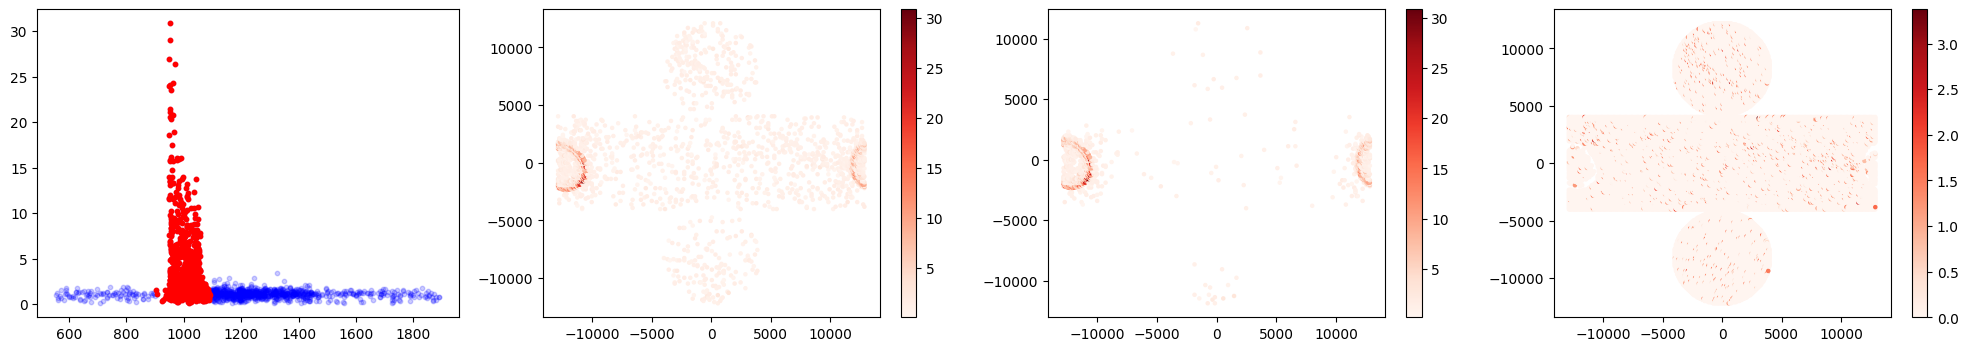

366 1098


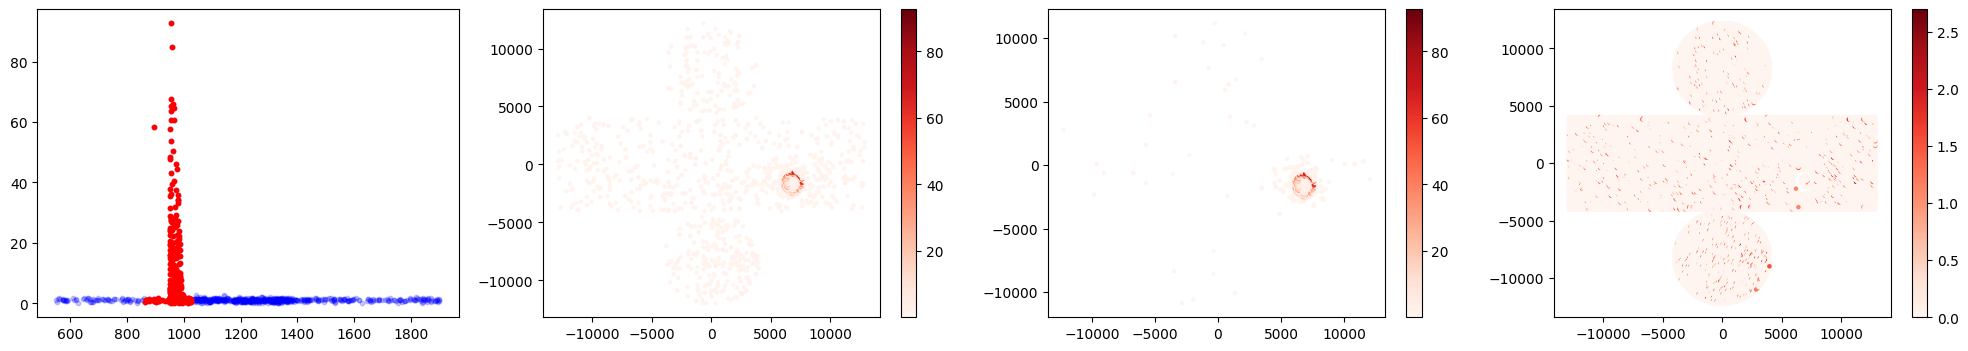

1598 2275


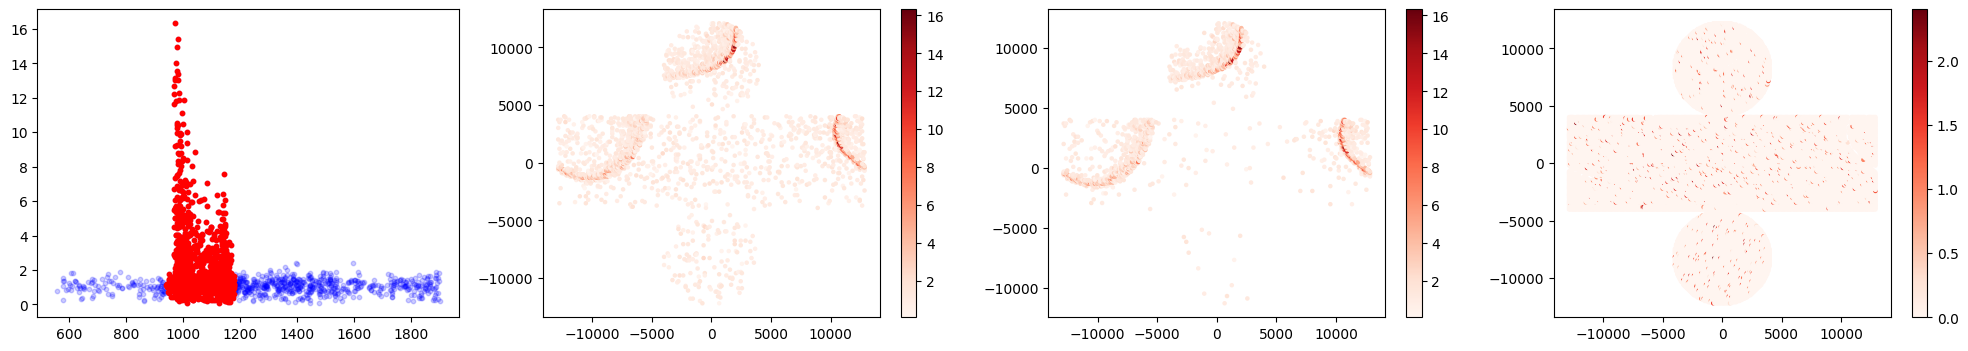

1565 2174


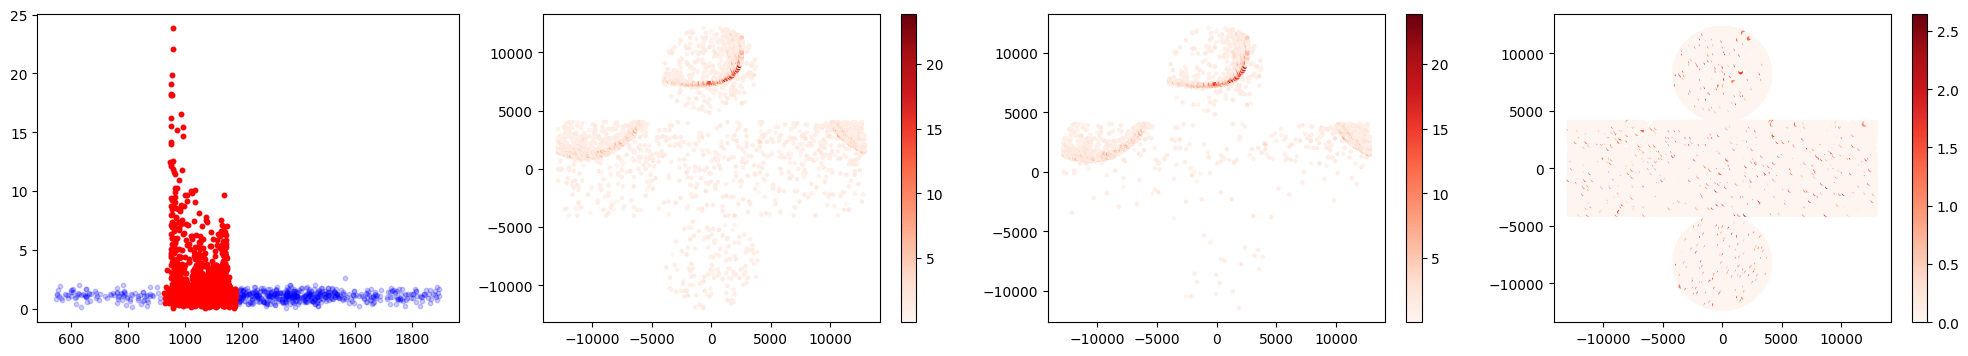

1325 1949


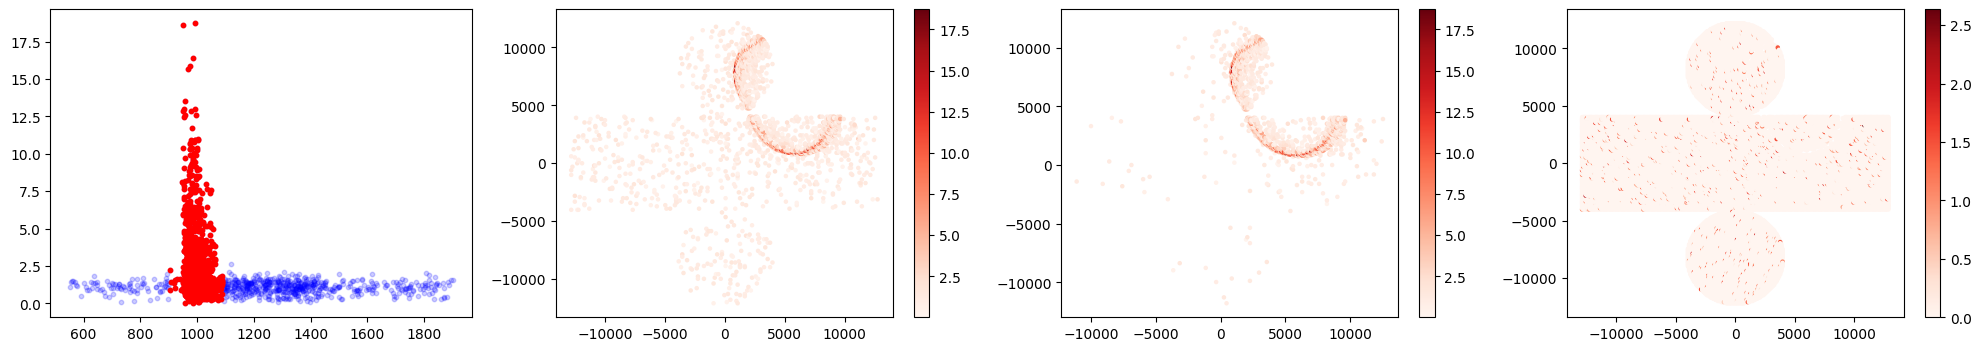

In [9]:
for i in range(5):
    

    # index = np.zeros((30912),dtype=bool) 

    # for i in range(90,190):
    #     condition = (out_pmt_t[0] > i * 10) & (out_pmt_t[0] <= (i * 10 + 10))
    #     if np.sum(condition) > 0:
            
    #         average = np.average(out_pmt_q[0][condition])
    #         if average > 2.5:
    #             index[condition] = True
    

    # plt.figure(figsize=(25,4))
    # plt.subplot(141)

    # plt.scatter(out_pmt_t[i][out_pmt_q[i]>0],out_pmt_q[i][out_pmt_q[i]>0],color='blue',s = 10,alpha=0.2)
    # plt.scatter(out_pmt_t[i][index],out_pmt_q[i][index],color='red',s = 10)
    # print(out_pmt_q[i][index].shape,out_pmt_q[i][out_pmt_t[i]>0].shape)


    

    # plt.rcParams['figure.figsize'] = (8, 5) 
    shift = 4106.4609*2*np.pi/4

    side_x1 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())], out_pmt_y[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())])/360)
    side_z1 = out_pmt_z[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())]


    side_x11 = side_x1[side_x1>shift]-3*shift
    side_z11 = side_z1[side_x1>shift]
    charge_1 = out_pmt_q[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x1>shift]
    time_1 = out_pmt_t[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x1>shift]


    side_x2 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())], out_pmt_y[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())])/360)
    side_z2 = out_pmt_z[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())]

    side_x21 = side_x1[side_x2<=shift]+shift
    side_z21 = side_z1[side_x2<=shift]
    charge_2 = out_pmt_q[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x2<=shift]
    time_2 = out_pmt_t[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x2<=shift]


    top_x = out_pmt_x[out_pmt_z>=out_pmt_z.max()]
    top_z = (out_pmt_z[out_pmt_z>=out_pmt_z.max()]+out_pmt_y[out_pmt_z>=out_pmt_z.max()]+4106.4609)
    charge_top = out_pmt_q[i][out_pmt_z>=out_pmt_z.max()]
    time_top = out_pmt_t[i][out_pmt_z>=out_pmt_z.max()]


    bottom_x = out_pmt_x[out_pmt_z<=-out_pmt_z.max()]
    bottom_z = (out_pmt_z[out_pmt_z<=-out_pmt_z.max()]+out_pmt_y[out_pmt_z<=-out_pmt_z.max()]-4106.4609)
    charge_bottom = out_pmt_q[i][out_pmt_z<=-out_pmt_z.max()]
    time_bottom = out_pmt_t[i][out_pmt_z<=-out_pmt_z.max()]

    xxx = np.concatenate([side_x11,side_x21,top_x,bottom_x])
    # zzz = np.concatenate([side_z11,side_z21,top_z,bottom_z])
    zzz = np.concatenate([side_z11,side_z21,top_z,np.abs(bottom_z)-4*4106.4609])
    qqq = np.concatenate([charge_1,charge_2,charge_top,charge_bottom])
    ttt = np.concatenate([time_1,time_2,time_top,time_bottom])



    index2 = np.zeros((30912),dtype=bool) 

    for k in range(500,2000,20):


        if (qqq>0).sum(0) > 5000:
            condition = (ttt > k) & (ttt <= (k + 20))
        
            if np.sum(condition) > 0:
                
                # average = np.average(qqq[condition])
                if qqq[condition][qqq[condition]>2].sum() > 100:
                # if average > 1.3:
                    index2[condition] = True

        elif ((qqq>0).sum(0) > 2700) & ((qqq>0).sum(0) <= 5000):
            condition = (ttt > k) & (ttt <= (k + 30))
        
            if np.sum(condition) > 0:
                
                # average = np.average(qqq[condition])
                if qqq[condition][qqq[condition]>2].sum() > 100:
                # if average > 1.3:
                    index2[condition] = True

        elif ((qqq>0).sum(0) > 2000) & ((qqq>0).sum(0) <= 2700):
            condition = (ttt > k) & (ttt <= (k + 40))
        
            if np.sum(condition) > 0:
                
                # average = np.average(qqq[condition])
                if qqq[condition][qqq[condition]>2].sum() > 30:
                # if average > 1.3:
                    index2[condition] = True
        else:
            condition = (ttt > k) & (ttt <= (k + 50))
            if np.sum(condition) > 0:
                
                # average = np.average(qqq[condition])
                if qqq[condition][qqq[condition]>2].sum() > 20:
                # if average > 1.3:
                    index2[condition] = True
        



    # index3 = qqq > 0.8
    # index = index2 & index3
    index = index2
    
    # index2 = ((ttt > 930) & (ttt <=1400))
    plt.figure(figsize=(25,4))
    plt.subplot(141)

    plt.scatter(ttt[qqq>0],qqq[qqq>0],color='blue',s = 10,alpha=0.2)
    plt.scatter(ttt[index],qqq[index],color='red',s = 10)
    print(index.sum(), (qqq>0).sum())


    


    plt.subplot(142)
    plt.scatter(xxx[qqq>0],zzz[qqq>0],s = 5, c= qqq[qqq>0],cmap='Reds')
    plt.colorbar()

    plt.subplot(143)
    plt.scatter(xxx[index],zzz[index],s = 5, c= qqq[index],cmap='Reds')
    plt.colorbar()
    
    plt.subplot(144)
    plt.scatter(xxx[~index],zzz[~index],s = 5, c= qqq[~index],cmap='Reds')
    # plt.scatter(xxx[(ttt>cut_time2)],zzz[(ttt>cut_time2)],s = 5, c= qqq[(ttt>cut_time2)],cmap='Reds')
    plt.colorbar()
    
    
    
    plt.show()
    

In [10]:
# for i in range(50):
    

#     # index = np.zeros((30912),dtype=bool) 

#     # for i in range(90,190):
#     #     condition = (out_pmt_t[0] > i * 10) & (out_pmt_t[0] <= (i * 10 + 10))
#     #     if np.sum(condition) > 0:
            
#     #         average = np.average(out_pmt_q[0][condition])
#     #         if average > 2.5:
#     #             index[condition] = True
    

#     # plt.figure(figsize=(25,4))
#     # plt.subplot(141)

#     # plt.scatter(out_pmt_t[i][out_pmt_q[i]>0],out_pmt_q[i][out_pmt_q[i]>0],color='blue',s = 10,alpha=0.2)
#     # plt.scatter(out_pmt_t[i][index],out_pmt_q[i][index],color='red',s = 10)
#     # print(out_pmt_q[i][index].shape,out_pmt_q[i][out_pmt_t[i]>0].shape)


    

#     # plt.rcParams['figure.figsize'] = (8, 5) 
#     shift = 4106.4609*2*np.pi/4

#     side_x1 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())], out_pmt_y[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())])/360)
#     side_z1 = out_pmt_z[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())]


#     side_x11 = side_x1[side_x1>shift]-3*shift
#     side_z11 = side_z1[side_x1>shift]
#     charge_1 = out_pmt_q[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x1>shift]
#     time_1 = out_pmt_t[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x1>shift]


#     side_x2 = 2*np.pi*4106.7739*(calculate_angle(out_pmt_x[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())], out_pmt_y[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())])/360)
#     side_z2 = out_pmt_z[(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())]

#     side_x21 = side_x1[side_x2<=shift]+shift
#     side_z21 = side_z1[side_x2<=shift]
#     charge_2 = out_pmt_q[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x2<=shift]
#     time_2 = out_pmt_t[i][(out_pmt_z>-out_pmt_z.max())&(out_pmt_z<out_pmt_z.max())][side_x2<=shift]


#     top_x = out_pmt_x[out_pmt_z>=out_pmt_z.max()]
#     top_z = (out_pmt_z[out_pmt_z>=out_pmt_z.max()]+out_pmt_y[out_pmt_z>=out_pmt_z.max()]+4106.4609)
#     charge_top = out_pmt_q[i][out_pmt_z>=out_pmt_z.max()]
#     time_top = out_pmt_t[i][out_pmt_z>=out_pmt_z.max()]


#     bottom_x = out_pmt_x[out_pmt_z<=-out_pmt_z.max()]
#     bottom_z = (out_pmt_z[out_pmt_z<=-out_pmt_z.max()]+out_pmt_y[out_pmt_z<=-out_pmt_z.max()]-4106.4609)
#     charge_bottom = out_pmt_q[i][out_pmt_z<=-out_pmt_z.max()]
#     time_bottom = out_pmt_t[i][out_pmt_z<=-out_pmt_z.max()]

#     xxx = np.concatenate([side_x11,side_x21,top_x,bottom_x])
#     # zzz = np.concatenate([side_z11,side_z21,top_z,bottom_z])
#     zzz = np.concatenate([side_z11,side_z21,top_z,np.abs(bottom_z)-4*4106.4609])
#     qqq = np.concatenate([charge_1,charge_2,charge_top,charge_bottom])
#     ttt = np.concatenate([time_1,time_2,time_top,time_bottom])



#     index2 = np.zeros((30912),dtype=bool) 

#     for k in range(500,2000,20):


#         if (qqq>0).sum(0) > 5000:
#             condition = (ttt > k) & (ttt <= (k + 20))
        
#             if np.sum(condition) > 0:
                
#                 # average = np.average(qqq[condition])
#                 if qqq[condition][qqq[condition]>2].sum() > 100:
#                 # if average > 1.3:
#                     index2[condition] = True

#         elif ((qqq>0).sum(0) > 2700) & ((qqq>0).sum(0) <= 5000):
#             condition = (ttt > k) & (ttt <= (k + 30))
        
#             if np.sum(condition) > 0:
                
#                 # average = np.average(qqq[condition])
#                 if qqq[condition][qqq[condition]>2].sum() > 100:
#                 # if average > 1.3:
#                     index2[condition] = True

#         elif ((qqq>0).sum(0) > 2000) & ((qqq>0).sum(0) <= 2700):
#             condition = (ttt > k) & (ttt <= (k + 40))
        
#             if np.sum(condition) > 0:
                
#                 # average = np.average(qqq[condition])
#                 if qqq[condition][qqq[condition]>2].sum() > 30:
#                 # if average > 1.3:
#                     index2[condition] = True
#         else:
#             condition = (ttt > k) & (ttt <= (k + 50))
#             if np.sum(condition) > 0:
                
#                 # average = np.average(qqq[condition])
#                 if qqq[condition][qqq[condition]>2].sum() > 20:
#                 # if average > 1.3:
#                     index2[condition] = True
        



#     index3 = qqq > 1
#     index4 = index2 & index3
#     index = index2
    
#     # index2 = ((ttt > 930) & (ttt <=1400))
#     plt.figure(figsize=(25,4))
#     plt.subplot(141)

#     plt.scatter(ttt[qqq>0],qqq[qqq>0],color='blue',s = 10,alpha=0.2)
#     plt.scatter(ttt[index],qqq[index],color='red',s = 10)
#     print(index.sum(), (qqq>0).sum())


    


#     plt.subplot(142)
#     plt.scatter(xxx[qqq>0],zzz[qqq>0],s = 5, c= qqq[qqq>0],cmap='Reds')
#     plt.colorbar()

#     plt.subplot(143)
#     plt.scatter(xxx[index],zzz[index],s = 5, c= qqq[index],cmap='Reds')
#     plt.colorbar()
    
#     plt.subplot(144)
#     plt.scatter(xxx[index4],zzz[index4],s = 5, c= qqq[index4],cmap='Reds')

#     plt.colorbar()
    
    
    
#     plt.show()
    